In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os
import random
import time

# Inside the /Multimodal-Deep-Regression/notebooks
import sys
sys.path.append("..")

from util.utilities import train, evaluate

# import all the models from models module
from models import CNN3D

In [2]:
# Current Path
os.getcwd()

'/home/louis/Documents/gatech/Summer2023/Multimodal-Deep-Regression/notebooks'

In [3]:
x_dir = "../data/x_tensors/"
y_dir = "../data/y_tensors/"

x_files = sorted([os.path.join(x_dir, f) for f in os.listdir(x_dir)])
y_files = sorted([os.path.join(y_dir, f) for f in os.listdir(y_dir)])

# load all tensors
x_data = [torch.load(f) for f in x_files]
y_data = [torch.load(f) for f in y_files]

# list to tenors, cannot stack different depth or size
#x_data = torch.stack(x_data)
#y_data = torch.stack(y_data)

# Split the data
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, shuffle=False)
print(x_train[0].size())
print(x_val[0].size())
print(len(y_train))
print(len(y_val))

torch.Size([3, 128, 1024, 576])
torch.Size([3, 218, 1024, 576])
8
2


In [4]:
def generate_batch(batch):
    
    # max depth of each batch
    max_d = max([x.shape[1] for x, y in batch])
    padded_x = []
    y_batch = []

    for x, y in batch:
        d = x.shape[1]
        
        # ConstantPad3d (left, right, top, bottom, front, back)
        padding = nn.ConstantPad3d((0, 0, 0, 0, 0, max_d - d), 0)
        padded_x.append(padding(x))
        y_batch.append(y)

    x = torch.stack(padded_x)
    y = torch.tensor(y_batch)
    return x, y

In [5]:
# Create Batches with DataLoaders
batch_size = 1
train_loader = list(zip(x_train, y_train)) #TensorDataset(x_train, y_train)
val_loader = list(zip(x_val, y_val)) #TensorDataset(x_val, y_val)
train_loader = DataLoader(train_loader, batch_size=batch_size, shuffle=True, collate_fn=generate_batch)
val_loader = DataLoader(val_loader, batch_size=batch_size, shuffle=False, collate_fn=generate_batch)

In [6]:
model = CNN3D()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())#, lr=0.01)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")

EPOCHS = 20

train_losses = []
val_losses = []
start_time = time.time()

for epoch in range(EPOCHS):
    train_loss, avg_train_loss = train(model, train_loader, criterion, optimizer)
    val_loss, avg_val_loss = evaluate(model, val_loader, criterion)
    
    # record the losses
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # print every num times epoch only
    num = 1
    if ((epoch+1) % num == 0) or epoch == 0:
        if epoch == 0:
            time_took = (time.time() - start_time) / 60
            print(f'First epoch took {time_took:.1f} minutes.')
        print(f'Epoch {epoch+1}/{EPOCHS}, Train_Loss: {train_loss:.2f}, Avg: {avg_train_loss:.2f}; Val_Loss: {val_loss:.2f}, Avg: {avg_val_loss:.2f}')


Total parameters: 603981089
First epoch took -4.937513474623362 minutes.
Epoch 1/20, Train_Loss: 4152587790433184.00, Avg: 519073473804148.00; Val_Loss: 40103462305792.00, Avg: 20051731152896.00
Epoch 2/20, Train_Loss: 238356179419136.00, Avg: 29794522427392.00; Val_Loss: 59923626983424.00, Avg: 29961813491712.00
Epoch 3/20, Train_Loss: 97150176788480.00, Avg: 12143772098560.00; Val_Loss: 1386889609216.00, Avg: 693444804608.00
Epoch 4/20, Train_Loss: 2419769735168.00, Avg: 302471216896.00; Val_Loss: 32123471872.00, Avg: 16061735936.00
Epoch 5/20, Train_Loss: 269147086208.00, Avg: 33643385776.00; Val_Loss: 3340076928.00, Avg: 1670038464.00
Epoch 6/20, Train_Loss: 119032362528.00, Avg: 14879045316.00; Val_Loss: 915007808.00, Avg: 457503904.00
Epoch 7/20, Train_Loss: 86023118252.00, Avg: 10752889781.50; Val_Loss: 440621984.00, Avg: 220310992.00
Epoch 8/20, Train_Loss: 76568531944.00, Avg: 9571066493.00; Val_Loss: 303118112.00, Avg: 151559056.00
Epoch 9/20, Train_Loss: 72754302866.00, Avg:

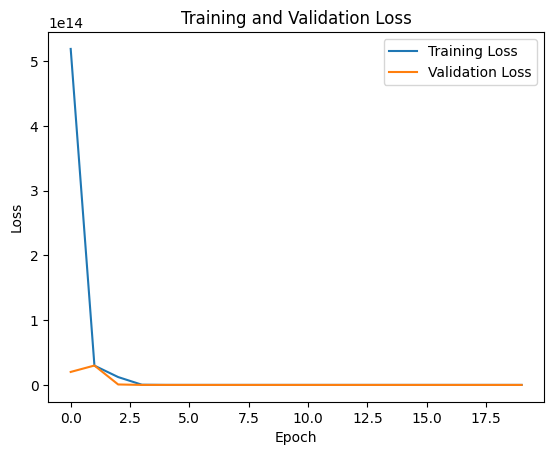

In [7]:
import matplotlib.pyplot as plt

# lost plot
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [8]:
# compare to validation set
val_values = []
predicted_values = []

for inputs, targets in val_loader:
    inputs, targets = inputs.to(torch.float32), targets.to(torch.float32)

    # Forward pass
    outputs = model(inputs)

    # Append the values
    val_values.extend(targets.tolist())
    predicted_values.extend(outputs.tolist())

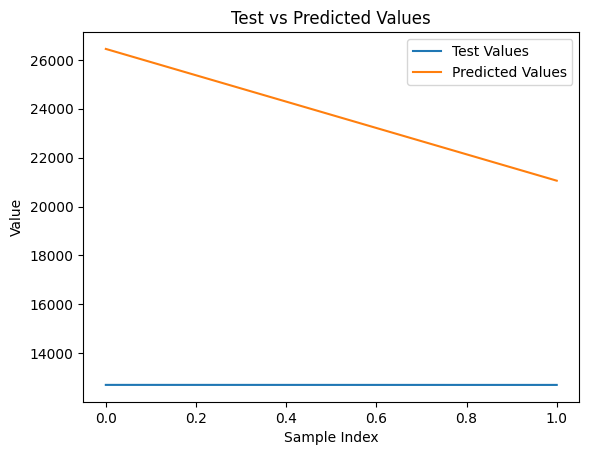

In [9]:
import matplotlib.pyplot as plt

plt.plot(val_values, label='Test Values')
plt.plot(predicted_values, label='Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Test vs Predicted Values')
plt.legend()
plt.show()

In [10]:
val_values, predicted_values

([[12701.103515625], [12699.748046875]], [[26447.94140625], [21056.44921875]])